# Surrogate Construction for Genz Functions: BCS

This notebook constructs a PC surrogate for Genz functions and gives the normalized root mean square error between the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [31]:
import numpy as np
import math  
from scipy.stats import qmc
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

We define our input parameters. BCS is best for undetermined models and/or large basis sets.

In [32]:
# PC parameters
nord = 6            # Order of the final PCE basis
ndim = 4            # Number of dimensions
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs

# BCS parameters
niter = 3                                        # Number of iterations to run, must be > 0
eta = 1/np.power(10,[i for i in range(1,16)])    # Threshold for stopping the algorithm
ntry = 5                                         # Number of splits for cross-validation of the retained basis terms 
eta_folds = 10                      # Number of folds to use for eta cross-validation                          
mindex_growth =  'conservative'              # Method for basis growth; options are "conservative," "nonconservative," or None
regparams = None                    # Regularization weights (provide an array or value); if None, they are autopopulated
sigma = 1e-8                        # Initial noise variance; updated in BCS
trval_frac = None                   # Fraction of total data to use in each split
npccut = None                       # Maximum number of PC coefficients to retain
pcf_thr = None                      # Minimum value (by magnitude) for PC coefficients
verbose = 0                         # Flag for print statements
eta_plot = True                     # Flag for plotting possible etas by RMSEs during optimization

# Model Choice 
model = 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

We randomly generate training and testing data.

In [33]:
# PC model with a full basis set
pc_model =  uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Random number generator
rng = qmc.LatinHypercube(d=ndim, seed=45)

#Training
nTrain = int(pc_model.GetNumberPCTerms()*1) # Number of training samples
x_tr_no_noise = 2*rng.random(n=nTrain)-1
x_train = x_tr_no_noise + np.random.normal(0, 0.1, size = x_tr_no_noise.shape)
y_train = func(x_tr_no_noise, model, np.ones(ndim+1))

#Testing
nTest = 10000  # Number of testing samples
x_test_no_noise = 2*rng.random(n=nTest)-1
x_test = x_test_no_noise + np.random.normal(0, 0.1, size = x_test_no_noise.shape)
y_test = func(x_test_no_noise, model, np.ones(ndim+1))

We perform BCS.

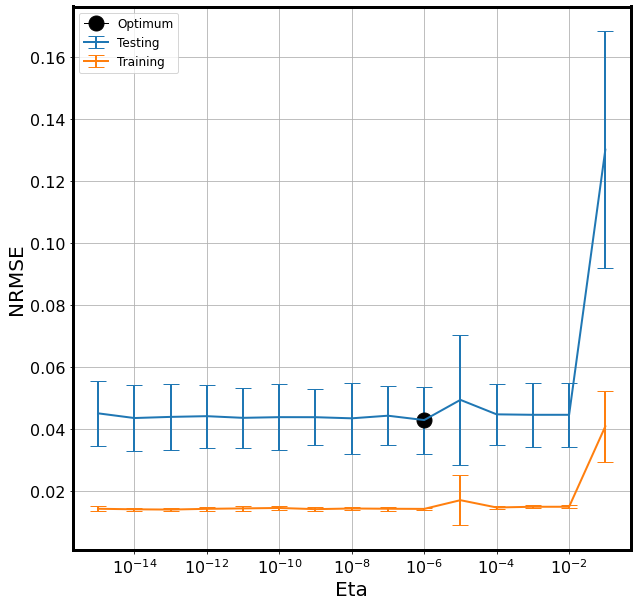

In [34]:
# PC object with the starting basis

# determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times
    
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter, eta, ntry, eta_folds, mindex_growth, regparams, sigma, trval_frac, npccut, pcf_thr, verbose, eta_plot)

Finally, we calculate the error.

In [35]:
# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.linalg.norm(y_test)
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 6 is


0.0020750837862156743